In [8]:

import os
import numpy as np
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ipywidgets import interact
%matplotlib ipympl


In [2]:
class Pyranos(object):
    def __init__(self,start_date=(2024,1,1),end_date=(2024,1,30)):
        #Function to load data from the Pyranos
        folder_path = "Data/"
        folder = os.listdir(folder_path)
        files_list = []
        
        
        time = []
        irr_cm22 = []
        irr_lps100p0 = []
        irr_bw = []
        irr_cm21 = []
        irr_sr25 = []
        temp = []
        self.date_times = []
        
        start_date = datetime(*start_date)
        end_date = datetime(*end_date)
        for file_name in folder:
            files_list.append(file_name)
        selected_dates = [string for string in files_list if start_date <= self.extract_date(string) <= end_date]
        print(selected_dates)
        for date in selected_dates:     
            with open(os.path.join(folder_path, date), 'r') as file:
                reference_date = datetime.strptime(date[2:8], '%y%m%d')
            
                for line in file:
                    
                    parts = line.strip().split(',')
                    self.date_times.append(self.value_to_datetime(parts[3],reference_date))
                    time.append(parts[3])
                    irr_cm22.append(parts[4])
                    irr_lps100p0.append(parts[8])
                    irr_bw.append(parts[11])
                    irr_cm21.append(parts[14])
                    irr_sr25.append(parts[18])
                    temp.append(parts[7])
                        
        self.time = np.array(time,dtype=float)
        self.irr_cm22 = np.array(irr_cm22,dtype=float)
        self.irr_lps100p0 = np.array(irr_lps100p0,dtype=float)
        self.irr_bw = np.array(irr_bw,dtype=float)
        self.irr_cm21 = np.array(irr_cm21,dtype=float)
        self.irr_sr25 = np.array(irr_sr25,dtype=float)
        self.temp= np.array(temp,dtype=float)


    def extract_date(self,string):
        date_str = string[2:8]  # Extract the date part from the string
        return datetime.strptime(date_str, '%y%m%d')
    
    def value_to_datetime(self, value ,reference_date):

        value = int(value)
            
        hours = value // 100
        minutes = value % 100
        
        time_delta = timedelta(hours=hours, minutes=minutes)
        datetime_obj = datetime.combine(reference_date, datetime.min.time()) + time_delta
        
        return datetime_obj
    

In [3]:
p = Pyranos(start_date=(2024,6,1),end_date=(2024,6,25))

['py240601.001', 'py240602.001', 'py240603.001', 'py240604.001', 'py240605.001', 'py240606.001', 'py240607.001', 'py240608.001', 'py240609.001', 'py240610.001', 'py240611.001', 'py240612.001', 'py240613.001', 'py240614.001', 'py240615.001', 'py240616.001', 'py240617.001', 'py240618.001', 'py240619.001', 'py240620.001', 'py240621.001', 'py240622.001', 'py240623.001', 'py240624.001', 'py240625.001']


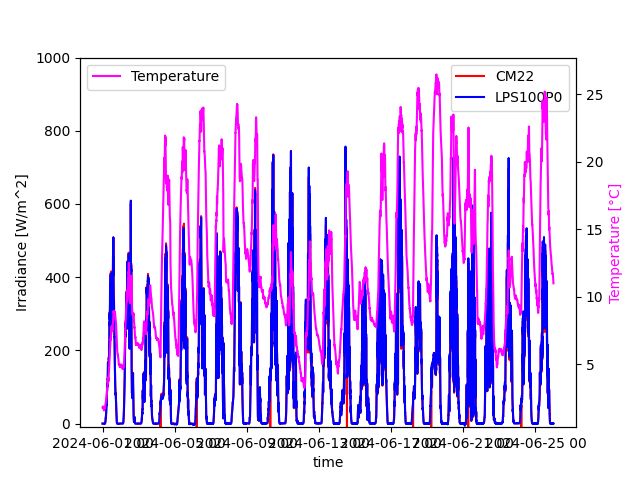

In [9]:
#time series 


fig,ax1 = plt.subplots()
ax1.set_ylabel('Irradiance [W/m^2]')
ax1.set_xlabel('time')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
#ax1.plot(p.date_times,p.irr_bw,color='black',label='B&W')
ax1.plot(p.date_times,p.irr_cm22,color='red',label='CM22')
#ax1.plot(p.date_times,p.irr_cm21,color='yellow',label='CM21')
ax1.plot(p.date_times,p.irr_lps100p0,color='blue',label='LPS100P0')
#ax1.plot(p.date_times,p.irr_sr25,color='orange',label='SR25')
#ax1.set_xlim(0,2400)
ax1.set_ylim(-10,1000)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel("Temperature [°C]")
ax2.plot(p.date_times,p.temp,color = 'magenta',label='Temperature')
ax2.legend(loc='upper left')
#ax2.set_ylim(-6,-1)
ax2.yaxis.label.set_color('magenta')
plt.show()


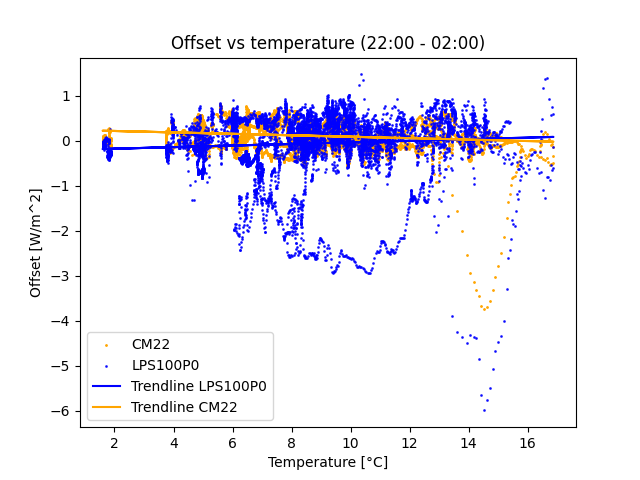

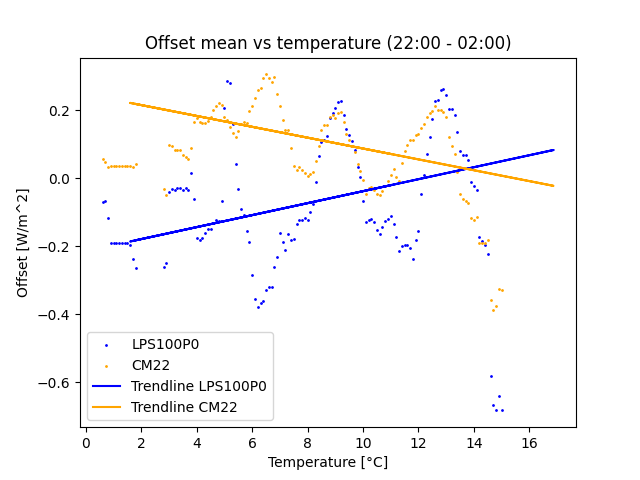

In [11]:

start_hour = 3
end_hour = 22
mask = [date.hour < start_hour or date.hour >= end_hour for date in p.date_times] 
  

time = [date for date, maske in zip(p.date_times, mask) if maske]




temp = p.temp[mask]
irr_cm22 = p.irr_cm22[mask]
irr_cm21 = p.irr_cm21[mask]
irr_bw = p.irr_bw[mask]
irr_lps100p0 = p.irr_lps100p0[mask]
irr_sr25 = p.irr_sr25[mask]

#Doing some data cleaning
irr_lps100p0[irr_lps100p0 < -1000] = np.nan    
mask = np.isfinite(irr_lps100p0)
temp = temp[mask]
irr_lps100p0 = irr_lps100p0[mask]
irr_cm22 = irr_cm22[mask]  


#Getting mean variables
mean_offsets_100 = []
mean_offsets_22 = []
temp_mean = []
i = 0
step=0.1
while i < 15:
    mask = (temp>=i)&(temp<=i+1)
    temp_filtered = temp[mask]
    irr100_filtered = irr_lps100p0[mask]
    irr22_filtered = irr_cm22[mask]
    mean_offsets_22.append(np.mean(irr22_filtered))
    mean_offsets_100.append(np.mean(irr100_filtered))
    temp_mean.append(i)
    i += step
    

plt.figure()
plt.title("Offset vs temperature (22:00 - 02:00)")
plt.ylabel("Offset [W/m^2]")
plt.xlabel('Temperature [°C]')
plt.scatter(temp,irr_cm22,s=1,color='orange',label='CM22')
#plt.scatter(irr_cm21,temp,s=1,color='yellow',label='CM21')
#plt.scatter(irr_bw,temp,s=1,color='black',label='BW')
plt.scatter(temp,irr_lps100p0,s=1,color='blue',label='LPS100P0',alpha=0.8)
#plt.scatter(irr_sr25,temp,s=1,color='orange',label='SR25')
#plt.ylim(9,10)
#plt.ylim(-3,3)
plt.legend()

#Getting trendline
slope, intercept = np.polyfit(temp, irr_lps100p0, 1)
trendline_100 = slope * temp + intercept
plt.plot(temp, trendline_100, color='blue', label='Trendline LPS100P0')

slope, intercept = np.polyfit(temp, irr_cm22, 1)
trendline_22 = slope * temp + intercept
plt.plot(temp, trendline_22, color='orange', label='Trendline CM22')

plt.legend()


fig,ax = plt.subplots()

plt.title("Offset mean vs temperature (22:00 - 02:00)")
ax.set_ylabel("Offset [W/m^2]")
ax.set_xlabel('Temperature [°C]')
ax.scatter(temp_mean,mean_offsets_100,s=1,color='blue',label='LPS100P0')
ax.scatter(temp_mean,mean_offsets_22,s=1,color='orange',label='CM22')
ax.plot(temp, trendline_100, color='blue', label='Trendline LPS100P0')
ax.plot(temp, trendline_22, color='orange', label='Trendline CM22')
plt.legend()
